In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf


/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

In [2]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits, dataset="L1000")

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [3]:
# Prepare data for training

meta_features = infer_L1000_features(data_dict["train"], metadata=True)
profile_features = infer_L1000_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(profile_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(profile_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(profile_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(profile_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [4]:
print(train_features_df.shape)
train_features_df.head(3)

(94440, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.74578,-0.007757,-0.063908,-0.115210,0.83776,-0.80023,-0.25787,-0.621180,-0.53313,-0.260430,...,-0.458550,0.51684,2.86550,-0.152210,-0.907810,1.47600,-0.42918,-0.81612,0.28533,0.37183
1,-0.29710,-0.180930,0.482090,-0.337130,-0.47045,-0.44483,0.38475,-0.566390,0.27726,0.000645,...,0.008161,-0.33238,-0.20174,-0.605390,0.024792,0.60759,0.41555,0.50640,0.23908,-0.23696
2,-0.75812,-0.283820,0.594330,0.089136,-0.85230,-0.78754,0.20291,0.018564,-0.22745,-0.839810,...,0.289560,0.16598,0.54440,-0.053607,0.439350,0.42920,-0.37040,-0.51931,-0.21799,-1.29360


In [5]:
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

In [6]:
train_features_df = shuffle_each_column(train_features_df)
valid_features_df = shuffle_each_column(valid_features_df)

In [7]:
encoder_architecture = [500]
decoder_architecture = [500]

In [8]:
L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=65,
    batch_size=512,
    encoder_batch_norm=True,
    epochs=180,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=40,
    verbose=True,
)

L1000_vae.compile_vae()

2022-01-14 02:32:44.234929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-14 02:32:44.234972: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-14 02:32:44.235000: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-3-81): /proc/driver/nvidia/version does not exist
2022-01-14 02:32:44.235276: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/keras/optimizer_v

In [9]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

2022-01-14 02:32:45.351870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/180
185/185 [==============================] - 7s 30ms/step - loss: 2946.1436 - recon: 2057.7424 - kl: 888.4011 - mmd: 888.4011 - val_loss: 3078.3647 - val_recon: 2056.6907 - val_kl: 1021.6740 - val_mmd: 1021.6740
Epoch 2/180
185/185 [==============================] - 5s 25ms/step - loss: 2255.7427 - recon: 2049.6589 - kl: 206.0838 - mmd: 206.0838 - val_loss: 2222.5295 - val_recon: 2059.0298 - val_kl: 163.4997 - val_mmd: 163.4997
Epoch 3/180
185/185 [==============================] - 5s 25ms/step - loss: 2171.9819 - recon: 2049.3621 - kl: 122.6204 - mmd: 122.6204 - val_loss: 2172.6072 - val_recon: 2058.6362 - val_kl: 113.9708 - val_mmd: 113.9708
Epoch 4/180
185/185 [==============================] - 5s 26ms/step - loss: 2148.4099 - recon: 2048.8928 - kl: 99.5166 - mmd: 99.5166 - val_loss: 2149.6865 - val_recon: 2058.3938 - val_kl: 91.2926 - val_mmd: 91.2926
Epoch 5/180
185/185 [==============================] - 5s 25ms/step - loss: 2132.7297 - recon: 2048.7170 - kl: 84.0128 - m

185/185 [==============================] - 5s 26ms/step - loss: 2054.3103 - recon: 2054.3081 - kl: 0.0021 - mmd: 0.0021 - val_loss: 2063.9880 - val_recon: 2063.9863 - val_kl: 0.0019 - val_mmd: 0.0019
Epoch 40/180
185/185 [==============================] - 5s 25ms/step - loss: 2054.2876 - recon: 2054.2864 - kl: 0.0018 - mmd: 0.0018 - val_loss: 2063.9958 - val_recon: 2063.9946 - val_kl: 0.0014 - val_mmd: 0.0014
Epoch 41/180
185/185 [==============================] - 5s 26ms/step - loss: 2054.3035 - recon: 2054.3020 - kl: 0.0016 - mmd: 0.0016 - val_loss: 2063.9854 - val_recon: 2063.9836 - val_kl: 0.0013 - val_mmd: 0.0013
Epoch 42/180
185/185 [==============================] - 5s 27ms/step - loss: 2054.2932 - recon: 2054.2915 - kl: 0.0014 - mmd: 0.0014 - val_loss: 2063.9368 - val_recon: 2063.9358 - val_kl: 0.0014 - val_mmd: 0.0014
Epoch 43/180
185/185 [==============================] - 5s 26ms/step - loss: 2054.3025 - recon: 2054.3010 - kl: 0.0014 - mmd: 0.0014 - val_loss: 2064.0061 - val_

185/185 [==============================] - 5s 25ms/step - loss: 2054.2825 - recon: 2054.2788 - kl: 0.0035 - mmd: 0.0035 - val_loss: 2063.9517 - val_recon: 2063.9482 - val_kl: 0.0035 - val_mmd: 0.0035
Epoch 77/180
185/185 [==============================] - 5s 25ms/step - loss: 2054.2793 - recon: 2054.2742 - kl: 0.0049 - mmd: 0.0049 - val_loss: 2063.9800 - val_recon: 2063.9751 - val_kl: 0.0045 - val_mmd: 0.0045
Epoch 78/180
185/185 [==============================] - 5s 25ms/step - loss: 2054.2747 - recon: 2054.2676 - kl: 0.0067 - mmd: 0.0067 - val_loss: 2063.9700 - val_recon: 2063.9634 - val_kl: 0.0067 - val_mmd: 0.0067
Epoch 79/180
185/185 [==============================] - 5s 25ms/step - loss: 2054.2793 - recon: 2054.2715 - kl: 0.0092 - mmd: 0.0092 - val_loss: 2063.9719 - val_recon: 2063.9631 - val_kl: 0.0092 - val_mmd: 0.0092
Epoch 80/180
185/185 [==============================] - 5s 25ms/step - loss: 2054.2900 - recon: 2054.2800 - kl: 0.0101 - mmd: 0.0101 - val_loss: 2063.9456 - val_

185/185 [==============================] - 5s 25ms/step - loss: 2054.2610 - recon: 2054.2539 - kl: 0.0071 - mmd: 0.0071 - val_loss: 2063.9287 - val_recon: 2063.9192 - val_kl: 0.0095 - val_mmd: 0.0095
Epoch 115/180
185/185 [==============================] - 5s 25ms/step - loss: 2054.2478 - recon: 2054.2405 - kl: 0.0069 - mmd: 0.0069 - val_loss: 2063.9355 - val_recon: 2063.9277 - val_kl: 0.0080 - val_mmd: 0.0080
Epoch 116/180
185/185 [==============================] - 5s 25ms/step - loss: 2054.2595 - recon: 2054.2520 - kl: 0.0069 - mmd: 0.0069 - val_loss: 2063.9580 - val_recon: 2063.9509 - val_kl: 0.0068 - val_mmd: 0.0068
Epoch 117/180
185/185 [==============================] - 5s 25ms/step - loss: 2054.2522 - recon: 2054.2456 - kl: 0.0067 - mmd: 0.0067 - val_loss: 2063.9541 - val_recon: 2063.9446 - val_kl: 0.0099 - val_mmd: 0.0099
Epoch 118/180
185/185 [==============================] - 5s 26ms/step - loss: 2054.2500 - recon: 2054.2427 - kl: 0.0074 - mmd: 0.0074 - val_loss: 2063.9153 - 

185/185 [==============================] - 5s 25ms/step - loss: 2054.2356 - recon: 2054.2295 - kl: 0.0050 - mmd: 0.0050 - val_loss: 2063.9204 - val_recon: 2063.9150 - val_kl: 0.0053 - val_mmd: 0.0053
Epoch 153/180
185/185 [==============================] - 5s 26ms/step - loss: 2054.2295 - recon: 2054.2256 - kl: 0.0049 - mmd: 0.0049 - val_loss: 2063.9609 - val_recon: 2063.9531 - val_kl: 0.0076 - val_mmd: 0.0076
Epoch 154/180
185/185 [==============================] - 5s 26ms/step - loss: 2054.2346 - recon: 2054.2288 - kl: 0.0048 - mmd: 0.0048 - val_loss: 2063.8977 - val_recon: 2063.8914 - val_kl: 0.0067 - val_mmd: 0.0067
Epoch 155/180
185/185 [==============================] - 5s 25ms/step - loss: 2054.2373 - recon: 2054.2322 - kl: 0.0049 - mmd: 0.0049 - val_loss: 2063.9187 - val_recon: 2063.9119 - val_kl: 0.0065 - val_mmd: 0.0065
Epoch 156/180
185/185 [==============================] - 5s 26ms/step - loss: 2054.2322 - recon: 2054.2275 - kl: 0.0049 - mmd: 0.0049 - val_loss: 2063.9399 - 

In [10]:
L1000_vae.vae

In [11]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,2946.143555,2057.742432,888.401123,888.401123,3078.364746,2056.690674,1021.673950,1021.673950
1,2255.742676,2049.658936,206.083801,206.083801,2222.529541,2059.029785,163.499695,163.499695
2,2171.981934,2049.362061,122.620438,122.620438,2172.607178,2058.636230,113.970795,113.970795
3,2148.409912,2048.892822,99.516624,99.516624,2149.686523,2058.393799,91.292633,91.292633
4,2132.729736,2048.717041,84.012833,84.012833,2136.216309,2058.335205,77.881485,77.881485
...,...,...,...,...,...,...,...,...
175,2054.228516,2054.225098,0.003116,0.003116,2063.869141,2063.862305,0.006331,0.006331
176,2054.227051,2054.223145,0.003448,0.003448,2063.940430,2063.928955,0.011599,0.011599
177,2054.229980,2054.226562,0.003119,0.003119,2063.895020,2063.892334,0.002525,0.002525
178,2054.221191,2054.217773,0.002662,0.002662,2063.910156,2063.907227,0.002541,0.002541


In [13]:
encoder = L1000_vae.encoder_block["encoder"]
decoder = L1000_vae.decoder_block["decoder"]
encoder.save("models/L1000EncoderShuffled_beta")
decoder.save("models/L1000DecoderShuffled_beta")

2022-01-14 02:50:41.123604: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/L1000EncoderShuffled_beta/assets
INFO:tensorflow:Assets written to: models/L1000DecoderShuffled_beta/assets


In [ ]:
# history_df.to_csv('L1000_training_random.csv')

In [ ]:
# original_training_data  = pd.read_csv('twolayer_training.csv')

In [ ]:
# plt.figure(figsize=(7, 5), dpi = 400)
# plt.plot(original_training_data["loss"], label="Training data")
# plt.plot(original_training_data["val_loss"], label="Validation data")
# plt.plot(history_df["loss"], label="Shuffled training data")
# plt.plot(history_df["val_loss"], label="Shuffled validation data")
# # plt.title("Loss for VAE training on Cell Painting Level 5 data")
# plt.ylabel("MSE + KL Divergence")
# plt.xlabel("No. Epoch")
# plt.legend()
# plt.show()

In [14]:
L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=65,
    batch_size=512,
    encoder_batch_norm=True,
    epochs=180,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)

L1000_vae.compile_vae()

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/180
185/185 [==============================] - 6s 27ms/step - loss: 2067.1572 - recon: 2038.1812 - kl: 28.9754 - mmd: 28.9754 - val_loss: 2056.9165 - val_recon: 2013.0303 - val_kl: 43.8863 - val_mmd: 43.8863
Epoch 2/180
185/185 [==============================] - 5s 25ms/step - loss: 2006.7651 - recon: 1976.4237 - kl: 30.3409 - mmd: 30.3409 - val_loss: 1989.3683 - val_recon: 1947.9327 - val_kl: 41.4354 - val_mmd: 41.4354
Epoch 3/180
185/185 [==============================] - 5s 25ms/step - loss: 1968.6726 - recon: 1929.5522 - kl: 39.1207 - mmd: 39.1207 - val_loss: 1963.8060 - val_recon: 1913.6410 - val_kl: 50.1651 - val_mmd: 50.1651
Epoch 4/180
185/185 [==============================] - 5s 25ms/step - loss: 1947.6011 - recon: 1900.9172 - kl: 46.6834 - mmd: 46.6834 - val_loss: 1951.0229 - val_recon: 1899.0208 - val_kl: 52.0021 - val_mmd: 52.0021
Epoch 5/180
185/185 [==============================] - 5s 25ms/step - loss: 1935.2810 - recon: 1884.7917 - kl: 50.4901 - mmd: 50.4901 - 

Epoch 39/180
185/185 [==============================] - 5s 25ms/step - loss: 1808.8376 - recon: 1746.6284 - kl: 62.2096 - mmd: 62.2096 - val_loss: 1824.2128 - val_recon: 1761.8435 - val_kl: 62.3693 - val_mmd: 62.3693
Epoch 40/180
185/185 [==============================] - 5s 25ms/step - loss: 1807.2177 - recon: 1744.3516 - kl: 62.8662 - mmd: 62.8662 - val_loss: 1822.9583 - val_recon: 1760.2660 - val_kl: 62.6921 - val_mmd: 62.6921
Epoch 41/180
185/185 [==============================] - 5s 25ms/step - loss: 1805.7231 - recon: 1742.2201 - kl: 63.5034 - mmd: 63.5034 - val_loss: 1821.2552 - val_recon: 1757.8619 - val_kl: 63.3929 - val_mmd: 63.3929
Epoch 42/180
185/185 [==============================] - 5s 25ms/step - loss: 1804.2609 - recon: 1740.0918 - kl: 64.1673 - mmd: 64.1673 - val_loss: 1820.3624 - val_recon: 1756.3384 - val_kl: 64.0242 - val_mmd: 64.0242
Epoch 43/180
185/185 [==============================] - 5s 26ms/step - loss: 1802.8265 - recon: 1738.0153 - kl: 64.8118 - mmd: 64.81

Epoch 77/180
185/185 [==============================] - 5s 25ms/step - loss: 1771.8306 - recon: 1691.6797 - kl: 80.1507 - mmd: 80.1507 - val_loss: 1795.5043 - val_recon: 1715.9375 - val_kl: 79.5672 - val_mmd: 79.5672
Epoch 78/180
185/185 [==============================] - 5s 25ms/step - loss: 1771.2837 - recon: 1690.9680 - kl: 80.3162 - mmd: 80.3162 - val_loss: 1794.4369 - val_recon: 1714.8207 - val_kl: 79.6164 - val_mmd: 79.6164
Epoch 79/180
185/185 [==============================] - 5s 25ms/step - loss: 1770.8708 - recon: 1690.4122 - kl: 80.4580 - mmd: 80.4580 - val_loss: 1794.3031 - val_recon: 1714.7880 - val_kl: 79.5147 - val_mmd: 79.5147
Epoch 80/180
185/185 [==============================] - 5s 26ms/step - loss: 1770.3101 - recon: 1689.7152 - kl: 80.5949 - mmd: 80.5949 - val_loss: 1794.0515 - val_recon: 1714.2319 - val_kl: 79.8195 - val_mmd: 79.8195
Epoch 81/180
185/185 [==============================] - 5s 25ms/step - loss: 1769.9282 - recon: 1689.1707 - kl: 80.7571 - mmd: 80.75

Epoch 115/180
185/185 [==============================] - 5s 25ms/step - loss: 1756.7112 - recon: 1672.6364 - kl: 84.0750 - mmd: 84.0750 - val_loss: 1784.4460 - val_recon: 1701.6047 - val_kl: 82.8411 - val_mmd: 82.8411
Epoch 116/180
185/185 [==============================] - 5s 25ms/step - loss: 1756.4595 - recon: 1672.3499 - kl: 84.1101 - mmd: 84.1101 - val_loss: 1784.3595 - val_recon: 1701.1548 - val_kl: 83.2047 - val_mmd: 83.2047
Epoch 117/180
185/185 [==============================] - 5s 25ms/step - loss: 1756.1776 - recon: 1671.9707 - kl: 84.2076 - mmd: 84.2076 - val_loss: 1784.3320 - val_recon: 1701.0309 - val_kl: 83.3014 - val_mmd: 83.3014
Epoch 118/180
185/185 [==============================] - 5s 25ms/step - loss: 1755.8899 - recon: 1671.6061 - kl: 84.2832 - mmd: 84.2832 - val_loss: 1783.8282 - val_recon: 1700.5931 - val_kl: 83.2350 - val_mmd: 83.2350
Epoch 119/180
185/185 [==============================] - 5s 25ms/step - loss: 1755.5210 - recon: 1671.1995 - kl: 84.3218 - mmd: 

185/185 [==============================] - 5s 25ms/step - loss: 1747.4006 - recon: 1661.3108 - kl: 86.0894 - mmd: 86.0894 - val_loss: 1777.9296 - val_recon: 1692.7190 - val_kl: 85.2104 - val_mmd: 85.2104
Epoch 153/180
185/185 [==============================] - 5s 25ms/step - loss: 1747.1956 - recon: 1661.0547 - kl: 86.1413 - mmd: 86.1413 - val_loss: 1777.7703 - val_recon: 1692.8215 - val_kl: 84.9488 - val_mmd: 84.9488
Epoch 154/180
185/185 [==============================] - 5s 25ms/step - loss: 1747.1597 - recon: 1660.9626 - kl: 86.1965 - mmd: 86.1965 - val_loss: 1777.8218 - val_recon: 1692.6106 - val_kl: 85.2110 - val_mmd: 85.2110
Epoch 155/180
185/185 [==============================] - 5s 25ms/step - loss: 1746.8809 - recon: 1660.6198 - kl: 86.2598 - mmd: 86.2598 - val_loss: 1777.5314 - val_recon: 1692.1777 - val_kl: 85.3538 - val_mmd: 85.3538
Epoch 156/180
185/185 [==============================] - 5s 26ms/step - loss: 1746.7355 - recon: 1660.4573 - kl: 86.2779 - mmd: 86.2779 - val_

In [16]:
L1000_vae.vae

In [17]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,2067.157227,2038.181152,28.975397,28.975397,2056.916504,2013.030273,43.886280,43.886280
1,2006.765137,1976.423706,30.340910,30.340910,1989.368286,1947.932739,41.435360,41.435360
2,1968.672607,1929.552246,39.120731,39.120731,1963.806030,1913.640991,50.165100,50.165100
3,1947.601074,1900.917236,46.683449,46.683449,1951.022949,1899.020752,52.002106,52.002106
4,1935.281006,1884.791748,50.490078,50.490078,1941.866333,1888.625854,53.240551,53.240551
...,...,...,...,...,...,...,...,...
175,1743.096802,1655.891602,87.204239,87.204239,1775.518188,1689.265747,86.252472,86.252472
176,1742.948730,1655.687256,87.261520,87.261520,1774.863892,1688.287354,86.577179,86.577179
177,1742.759155,1655.449585,87.309433,87.309433,1774.843384,1688.473999,86.369217,86.369217
178,1742.484497,1655.168945,87.314880,87.314880,1774.242798,1687.884277,86.358437,86.358437


In [18]:
encoder = L1000_vae.encoder_block["encoder"]
decoder = L1000_vae.decoder_block["decoder"]
encoder.save("models/L1000EncoderShuffled_vanilla")
decoder.save("models/L1000DecoderShuffled_vanilla")

INFO:tensorflow:Assets written to: models/L1000EncoderShuffled_vanilla/assets
INFO:tensorflow:Assets written to: models/L1000DecoderShuffled_vanilla/assets


In [23]:
# history_df.to_csv('L1000_training_vanilla_random.csv')

In [24]:
# original_training_data  = pd.read_csv('twolayer_training_vanilla.csv')

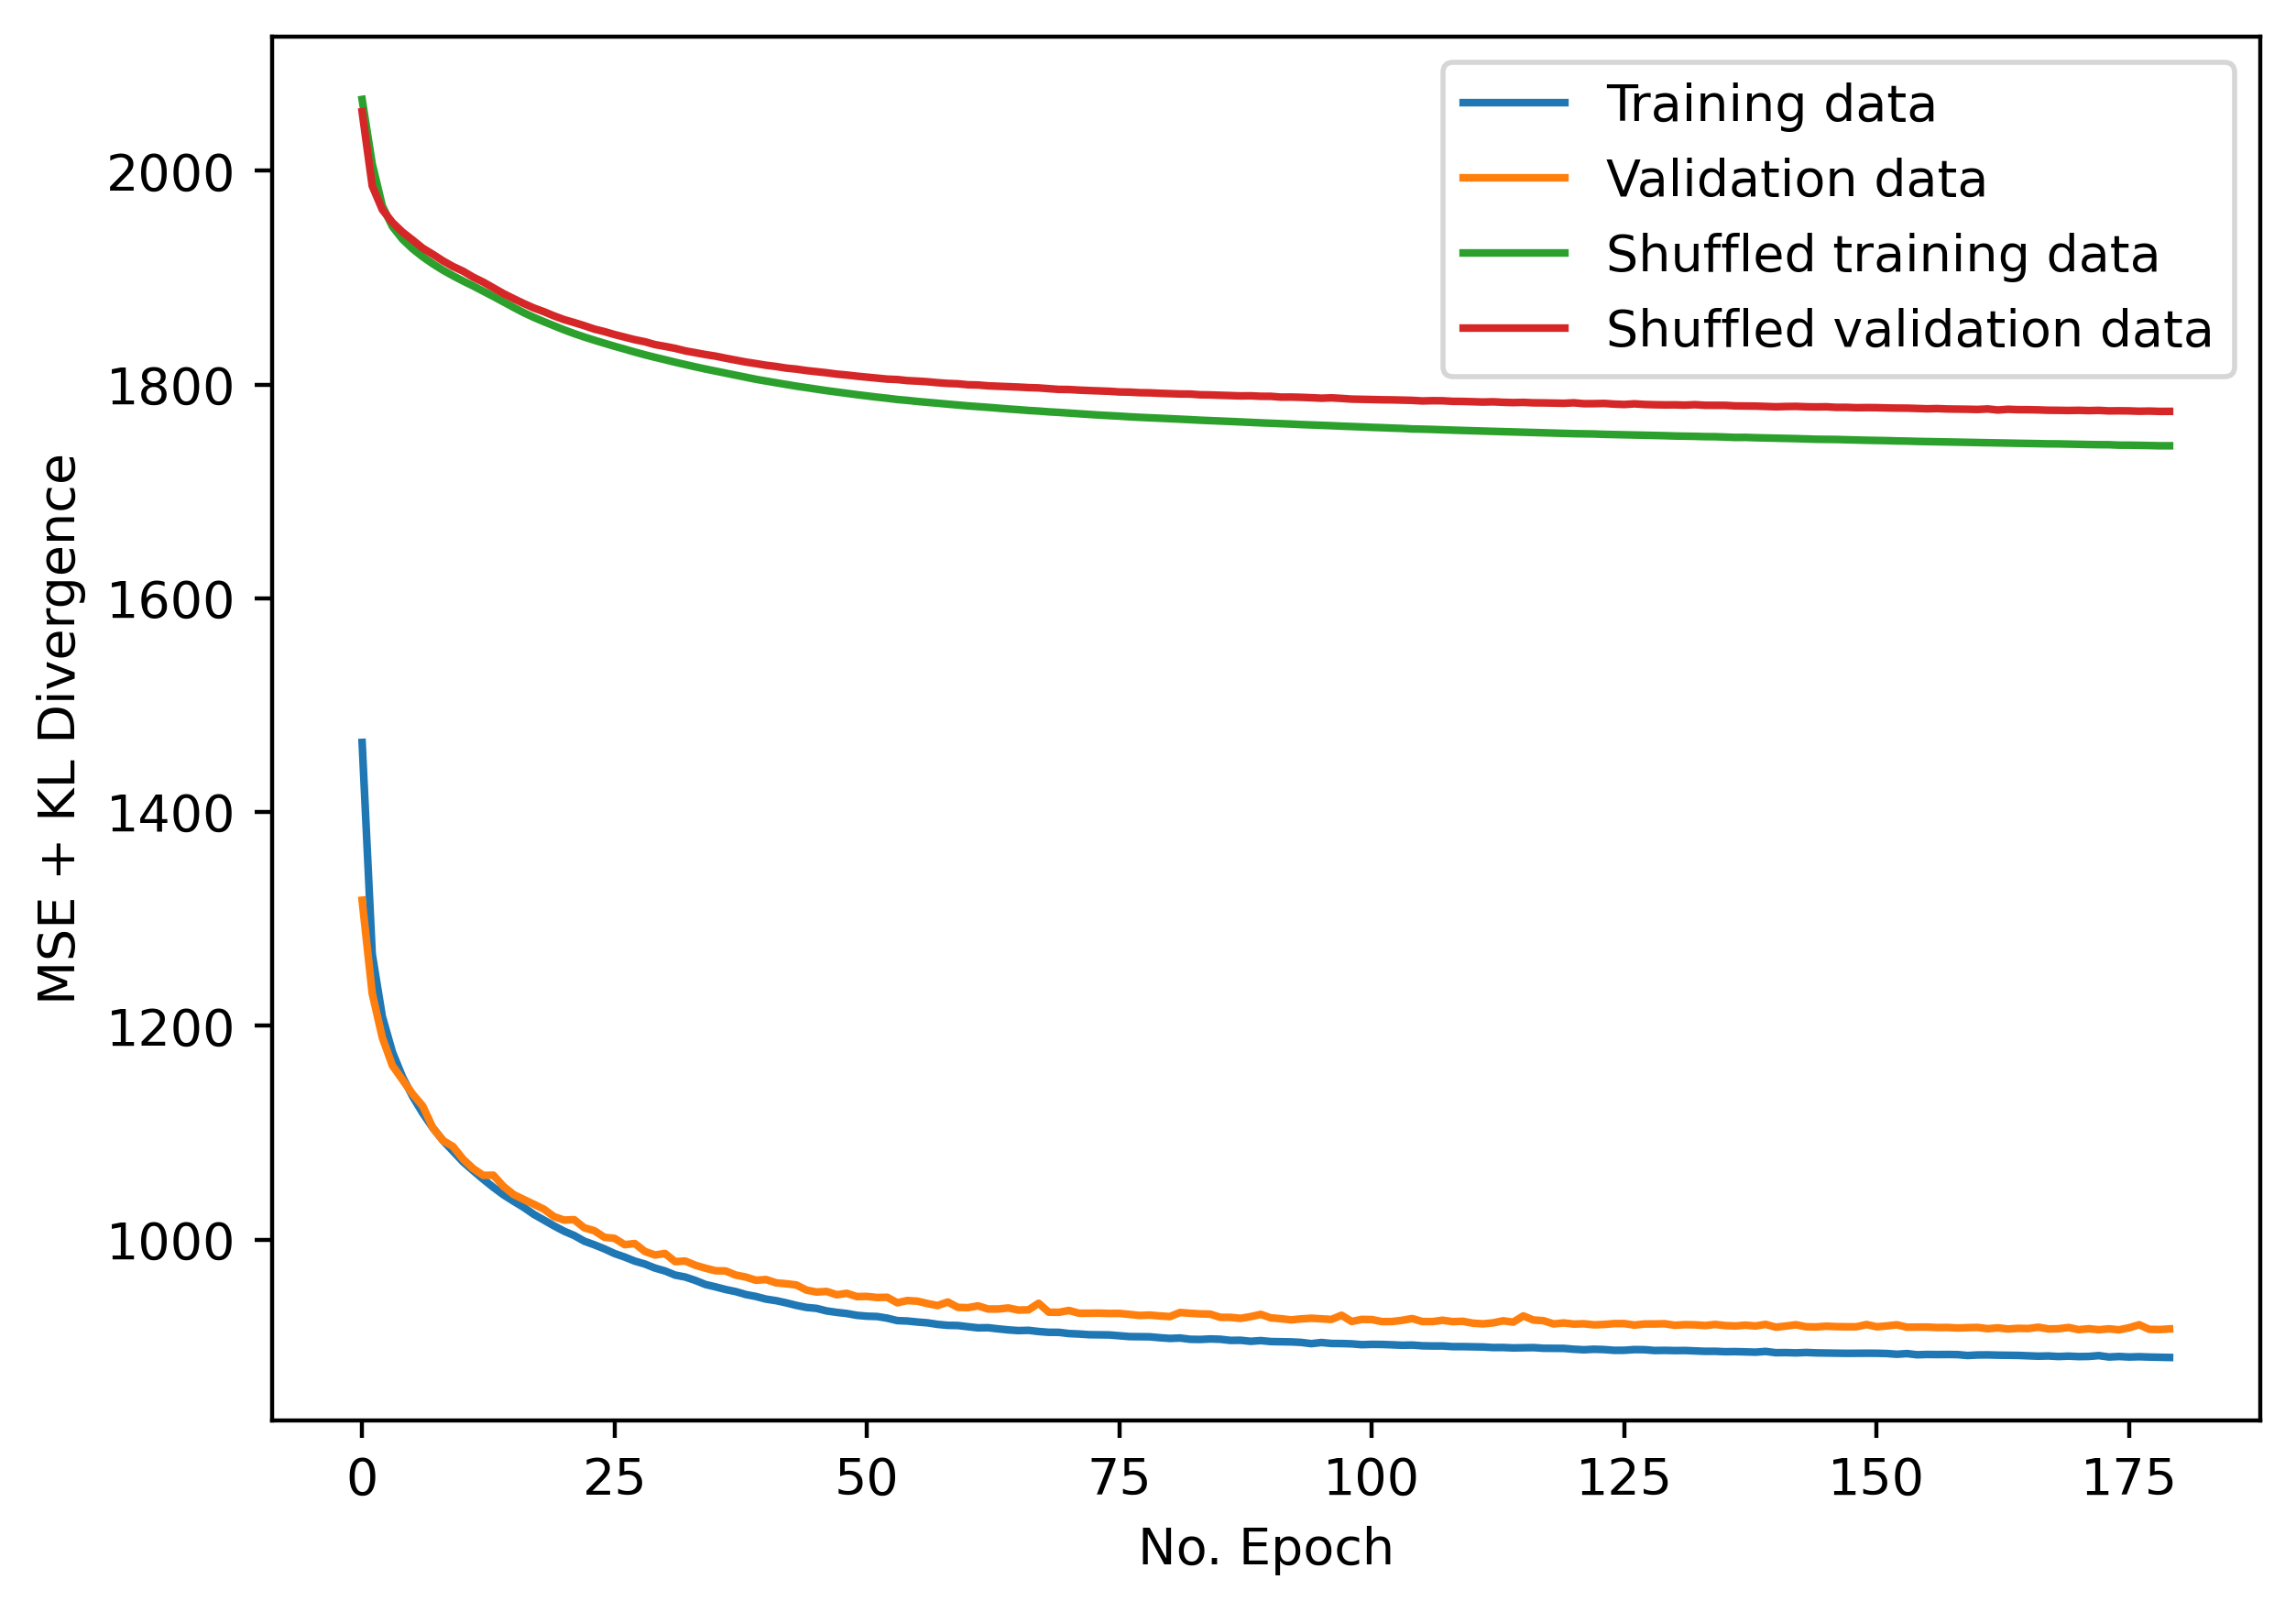

In [25]:
# plt.figure(figsize=(7, 5), dpi = 400)
# plt.plot(original_training_data["loss"], label="Training data")
# plt.plot(original_training_data["val_loss"], label="Validation data")
# plt.plot(history_df["loss"], label="Shuffled training data")
# plt.plot(history_df["val_loss"], label="Shuffled validation data")
# # plt.title("Loss for VAE training on Cell Painting Level 5 data")
# plt.ylabel("MSE + KL Divergence")
# plt.xlabel("No. Epoch")
# plt.legend()
# plt.show()

In [8]:
L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=65,
    batch_size=512,
    encoder_batch_norm=True,
    epochs=30,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0,
    lam=10000000,
    verbose=True,
)

L1000_vae.compile_vae()

2022-01-14 03:38:25.529805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-14 03:38:25.529847: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-14 03:38:25.529875: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-3-81): /proc/driver/nvidia/version does not exist
2022-01-14 03:38:25.530152: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/keras/optimizer_v

In [9]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

2022-01-14 03:38:27.664977: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
185/185 [==============================] - 28s 140ms/step - loss: 18467.9043 - recon: 2055.6035 - kl: 0.0000e+00 - mmd: 16321.3145 - val_loss: 7674.9888 - val_recon: 2050.8782 - val_kl: 0.0000e+00 - val_mmd: 7028.7290
Epoch 2/30
185/185 [==============================] - 25s 136ms/step - loss: 6989.9390 - recon: 2040.5955 - kl: 0.0000e+00 - mmd: 4964.0029 - val_loss: 3971.3721 - val_recon: 2051.1074 - val_kl: 0.0000e+00 - val_mmd: 2787.1133
Epoch 3/30
185/185 [==============================] - 25s 137ms/step - loss: 4073.9001 - recon: 2040.7485 - kl: 0.0000e+00 - mmd: 2055.4065 - val_loss: 3715.6460 - val_recon: 2050.3938 - val_kl: 0.0000e+00 - val_mmd: 2438.1777
Epoch 4/30
185/185 [==============================] - 25s 137ms/step - loss: 3493.1985 - recon: 2040.6194 - kl: 0.0000e+00 - mmd: 1450.9574 - val_loss: 3493.5847 - val_recon: 2049.5872 - val_kl: 0.0000e+00 - val_mmd: 2361.8340
Epoch 5/30
185/185 [==============================] - 25s 137ms/step - loss: 3325.5210 - r

In [10]:
L1000_vae.vae

In [11]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,18467.904297,2055.603516,0.0,16321.314453,7674.988770,2050.878174,0.0,7028.729004
1,6989.938965,2040.595459,0.0,4964.002930,3971.372070,2051.107422,0.0,2787.113281
2,4073.900146,2040.748535,0.0,2055.406494,3715.645996,2050.393799,0.0,2438.177734
3,3493.198486,2040.619385,0.0,1450.957397,3493.584717,2049.587158,0.0,2361.833984
4,3325.520996,2039.955933,0.0,1257.889893,3486.348145,2048.928955,0.0,2358.406494
5,3261.761963,2039.223389,0.0,1219.324463,3425.740723,2048.398438,0.0,2509.008057
6,3224.002686,2038.543213,0.0,1152.618286,3439.650391,2047.504761,0.0,2227.077881
7,3176.092529,2037.712646,0.0,1178.399780,3495.943359,2046.404175,0.0,2164.939941
8,3177.036865,2037.035156,0.0,1144.969482,3454.574219,2046.214844,0.0,2159.476318
9,3183.404053,2036.441284,0.0,1128.158203,3362.259277,2045.658081,0.0,2206.663330


In [13]:
encoder = L1000_vae.encoder_block["encoder"]
decoder = L1000_vae.decoder_block["decoder"]
encoder.save("models/L1000EncoderShuffled_mmd")
decoder.save("models/L1000DecoderShuffled_mmd")

2022-01-14 03:51:59.750907: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/L1000EncoderShuffled_mmd/assets
INFO:tensorflow:Assets written to: models/L1000DecoderShuffled_mmd/assets


In [12]:
# history_df.to_csv('L1000_training_mmd_random.csv')

In [14]:
# original_training_data  = pd.read_csv('twolayer_training_mmd.csv')

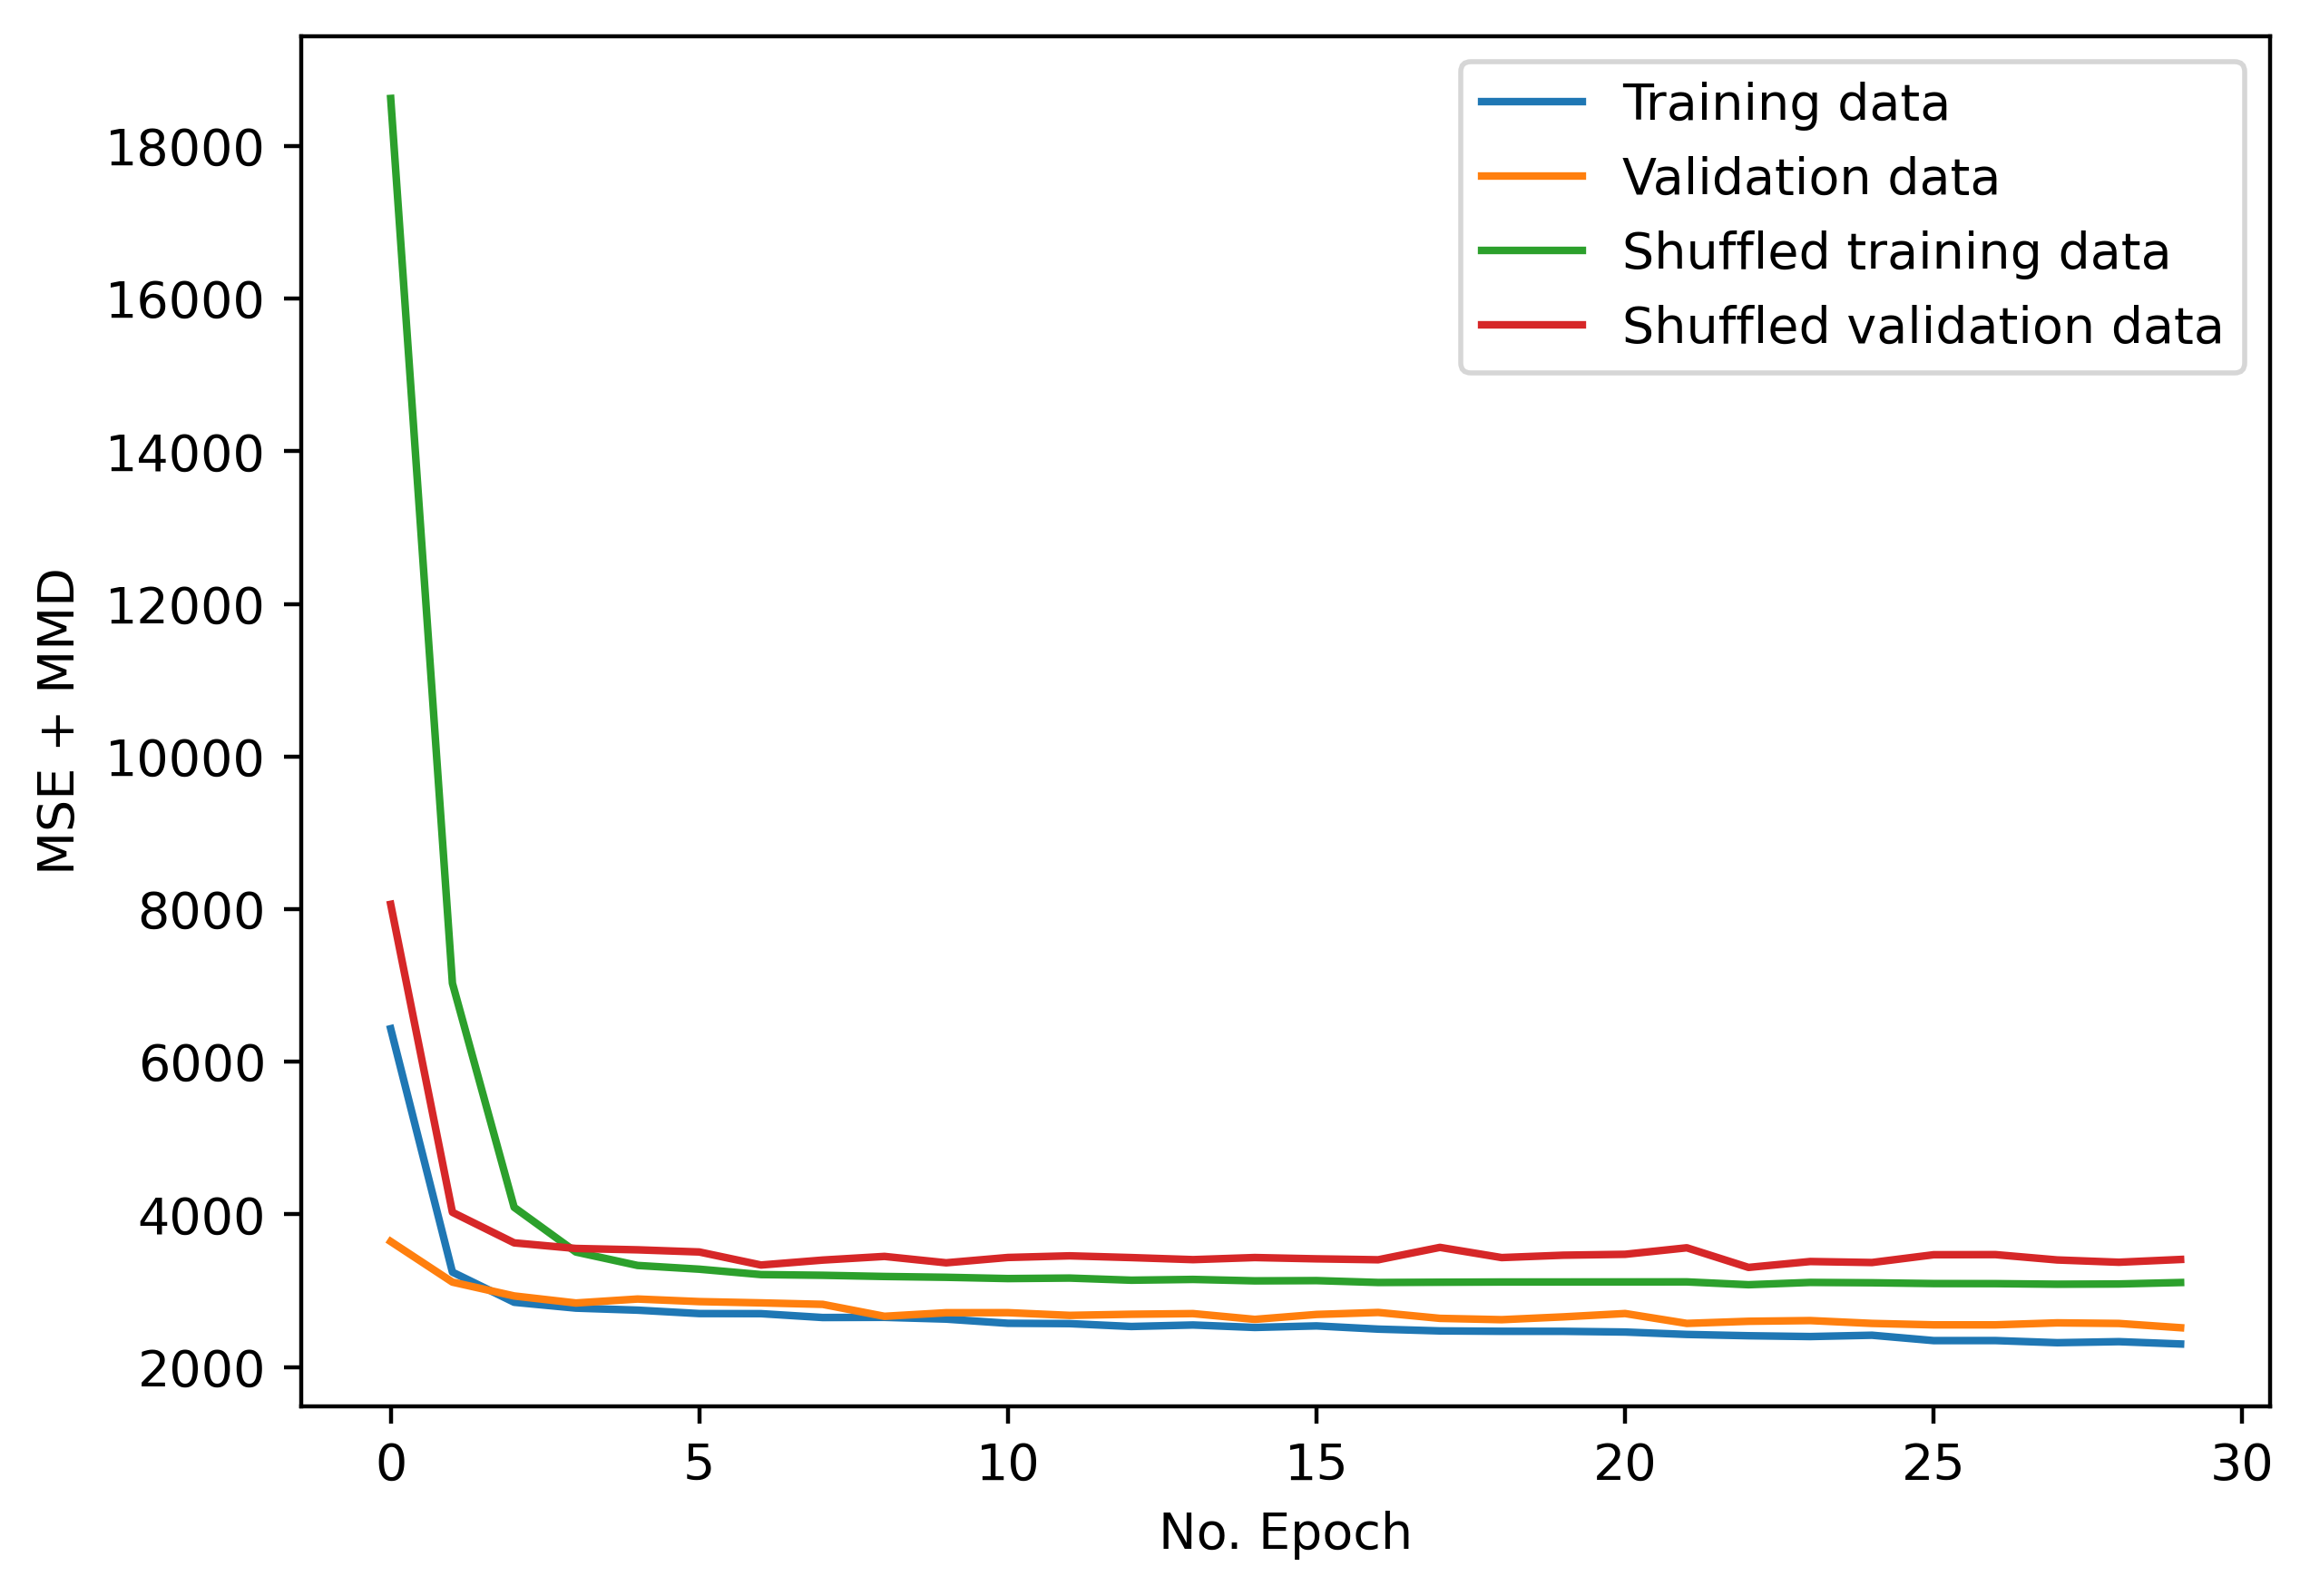

In [15]:
# plt.figure(figsize=(7, 5), dpi = 400)
# plt.plot(original_training_data["loss"], label="Training data")
# plt.plot(original_training_data["val_loss"], label="Validation data")
# plt.plot(history_df["loss"], label="Shuffled training data")
# plt.plot(history_df["val_loss"], label="Shuffled validation data")
# # plt.title("Loss for VAE training on Cell Painting Level 5 data")
# plt.ylabel("MSE + MMD")
# plt.xlabel("No. Epoch")
# plt.legend()
# plt.show()